<a href="https://colab.research.google.com/github/BogdanT54/Economic-Cycles-and-Market-Returns/blob/main/Markov_Switching_EGARCH_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instalare si incarcare pachete
install.packages("MSGARCH")  # doar daca nu este deja instalat
install.packages("forecast") # pentru modelul ARIMA
install.packages("tseries")  # teste de stationaritate
install.packages("ggplot2")
install.packages("rugarch")
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘zoo’, ‘expm’, ‘fanplot’, ‘numDeriv’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(zoo)
library(dplyr)
library(MSGARCH)
library(forecast)
library(tseries)
library(ggplot2)
library(rugarch)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




# **Citire si curatare date**

In [ ]:
bitcoin <- read.csv('/content/Bitcoin.csv')
oil <- read.csv('/content/CL=F.csv')
rotx <- read.csv('/content/ROTX.csv', sep = ';')
sp500 <- read.csv('/content/^GSPC.csv')
gold <- read.csv('/content/GC=F.csv')

gold$Date <- as.Date(gold$Date, format = "%m/%d/%Y")
rotx$Date <- as.Date(rotx$Date, format = "%m/%d/%Y")
sp500$Date <- as.Date(sp500$Date, format = "%m/%d/%Y")
oil$Date <- as.Date(oil$Date, format = "%m/%d/%Y")
bitcoin$Date <- as.Date(bitcoin$Date, format = "%m/%d/%Y")

gold_dates <- as.Date(gold$Date[])
rotx_dates <- as.Date(rotx$Date[])
sp500_dates <- as.Date(sp500$Date[])
oil_dates <- as.Date(oil$Date[-1])
bitcoin_dates <- as.Date(bitcoin$Date[])

In [ ]:
preprocess_log <- function(data) {
  data_valid <- data %>% filter(!is.na(Close), Close > 0)
  log_data <- log(data_valid$Close)
  log_returns <- diff(log_data)
  log_dates <- data_valid$Date[-1]
  return(data.frame(Date = log_dates, Close = log_returns))
}

# Aplici pentru fiecare activ:
bitcoin_log <- preprocess_log(bitcoin)
oil_log <- preprocess_log(oil)
rotx_log <- preprocess_log(rotx)
sp500_log <- preprocess_log(sp500)
gold_log <- preprocess_log(gold)

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `!is.na(Close)`.
[1mCaused by error:[22m
[33m![39m object 'Close' not found


# **Fitting ARIMA-GARCH**

In [ ]:
# Bitcoin (ARIMA(2,0,2))
model_arima_bitcoin <- arima(bitcoin_log$Close, order = c(2,0,2))
coefs <- model_arima_bitcoin$coef
se <- sqrt(diag(model_arima_bitcoin$var.coef))
z_values <- coefs / se
p_values <- 2 * (1 - pnorm(abs(z_values)))
result <- data.frame(Estimate = coefs, StdError = se, z = z_values, p_value = p_values)
print("Bitcoin ARIMA(2,0,2)")
print(result)
bitcoin_r <- data.frame(Date = bitcoin_log$Date, Close = residuals(model_arima_bitcoin))

[1] "Bitcoin ARIMA(2,0,2)"
              Estimate   StdError         z      p_value
ar1        0.472623700 0.10225294  4.622104 3.798681e-06
ar2        0.473709117 0.09986779  4.743362 2.101999e-06
ma1       -0.528537636 0.10655704 -4.960138 7.044302e-07
ma2       -0.388898179 0.10299393 -3.775933 1.594099e-04
intercept  0.002683379 0.00100159  2.679118 7.381638e-03


In [ ]:
# Oil (ARIMA(2,0,3))
model_arima_oil <- arima(oil_log$Close, order = c(2,0,3))
coefs <- model_arima_oil$coef
se <- sqrt(diag(model_arima_oil$var.coef))
z_values <- coefs / se
p_values <- 2 * (1 - pnorm(abs(z_values)))
result <- data.frame(Estimate = coefs, StdError = se, z = z_values, p_value = p_values)
print("Oil ARIMA(2,0,3)")
print(result)
oil_r <- data.frame(Date = oil_log$Date, Close = residuals(model_arima_oil))

[1] "Oil ARIMA(2,0,3)"
               Estimate     StdError           z      p_value
ar1        4.013882e-02 0.0464852772   0.8634738 0.3878770299
ar2       -8.531539e-01 0.0396425656 -21.5211570 0.0000000000
ma1       -9.009344e-02 0.0486170524  -1.8531242 0.0638645546
ma2        8.006991e-01 0.0455874266  17.5640340 0.0000000000
ma3       -6.093587e-02 0.0157565255  -3.8673415 0.0001100283
intercept  8.396207e-05 0.0003459441   0.2427042 0.8082345733


In [ ]:
# ROTX (ARIMA(3,0,3))
model_arima_rotx <- arima(rotx_log$Close, order = c(3,0,3))
coefs <- model_arima_rotx$coef
se <- sqrt(diag(model_arima_rotx$var.coef))
z_values <- coefs / se
p_values <- 2 * (1 - pnorm(abs(z_values)))
result <- data.frame(Estimate = coefs, StdError = se, z = z_values, p_value = p_values)
print("ROTX ARIMA(3,0,3)")
print(result)
rotx_r <- data.frame(Date = rotx_log$Date, Close = residuals(model_arima_rotx))

[1] "ROTX ARIMA(3,0,3)"
               Estimate     StdError          z      p_value
ar1        0.5972164907 0.1230667127  4.8527866 1.217387e-06
ar2       -0.3401189444 0.1035336542 -3.2851052 1.019443e-03
ar3        0.6816721069 0.1093161627  6.2357852 4.495175e-10
ma1       -0.5371708808 0.1149470031 -4.6732048 2.965359e-06
ma2        0.3392042906 0.0962326313  3.5248365 4.237443e-04
ma3       -0.7088865168 0.1043838108 -6.7911538 1.112399e-11
intercept  0.0002395865 0.0003098481  0.7732387 4.393811e-01


In [ ]:
# S&P500 (ARIMA(2,0,1))
model_arima_sp500 <- arima(sp500_log$Close, order = c(2,0,1))
coefs <- model_arima_sp500$coef
se <- sqrt(diag(model_arima_sp500$var.coef))
z_values <- coefs / se
p_values <- 2 * (1 - pnorm(abs(z_values)))
result <- data.frame(Estimate = coefs, StdError = se, z = z_values, p_value = p_values)
print("S&P500 ARIMA(2,0,1)")
print(result)
sp500_r <- data.frame(Date = sp500_log$Date, Close = residuals(model_arima_sp500))

Warning message in sqrt(diag(model_arima_sp500$var.coef)):
“NaNs produced”


[1] "S&P500 ARIMA(2,0,1)"
               Estimate    StdError        z    p_value
ar1       -0.0606692041         NaN      NaN        NaN
ar2       -0.0002434952         NaN      NaN        NaN
ma1       -0.0612644917         NaN      NaN        NaN
intercept  0.0003122201 0.000149995 2.081537 0.03738481


In [ ]:
# Gold (ARIMA(1,0,1))
model_arima_gold <- arima(gold_log$Close, order = c(1,0,1))
coefs <- model_arima_gold$coef
se <- sqrt(diag(model_arima_gold$var.coef))
z_values <- coefs / se
p_values <- 2 * (1 - pnorm(abs(z_values)))
result <- data.frame(Estimate = coefs, StdError = se, z = z_values, p_value = p_values)
print("Gold ARIMA(1,0,1)")
print(result)
gold_r <- data.frame(Date = gold_log$Date, Close = residuals(model_arima_gold))

Warning message in sqrt(diag(model_arima_gold$var.coef)):
“NaNs produced”


[1] "Gold ARIMA(1,0,1)"
               Estimate     StdError        z     p_value
ar1       -0.0017750875          NaN      NaN         NaN
ma1       -0.0020025002          NaN      NaN         NaN
intercept  0.0004048193 0.0001562544 2.590771 0.009576125


# **FITTING MS-GARCH**

In [ ]:
# Bitcoin - EGARCH(2,1) cu GED
spec_bitcoin <- CreateSpec(
  variance.spec = list(model = "eGARCH"),
  distribution.spec = list(distribution = "ged"),
  switch.spec = list(do.mix = FALSE, K = 3)
)

# Oil - EGARCH(1,1) cu skewed-t
spec_oil <- CreateSpec(
  variance.spec = list(model = "eGARCH"),
  distribution.spec = list(distribution = "sstd"),
  switch.spec = list(do.mix = FALSE, K = 2)
)

# ROTX - approximated FIGARCH(1,1) cu sGARCH(1,1) și Student-t
spec_rotx <- CreateSpec(
  variance.spec = list(model = "eGARCH"),
  distribution.spec = list(distribution = "std"),
  switch.spec = list(do.mix = FALSE, K = 2)
)

# S&P500 - EGARCH(2,1) cu skewed-t
spec_sp500 <- CreateSpec(
  variance.spec = list(model = "eGARCH"),
  distribution.spec = list(distribution = "sstd"),
  switch.spec = list(do.mix = FALSE, K = 2)
)

# Gold - EGARCH(1,1) cu skewed-t
spec_gold <- CreateSpec(
  variance.spec = list(model = "eGARCH"),
  distribution.spec = list(distribution = "sstd"),
  switch.spec = list(do.mix = FALSE, K = 2)
)

In [ ]:
# Bitcoin
fit_bitcoin <- FitML(spec = spec_bitcoin, data = bitcoin_r$Close)
summary(fit_bitcoin)
TransMat(fit_bitcoin)

Specification type: Markov-switching
Specification name: eGARCH_ged eGARCH_ged eGARCH_ged
Number of parameters in each variance model: 4 4 4
Number of parameters in each distribution: 1 1 1
------------------------------------------
Fixed parameters:
None
------------------------------------------
Across regime constrained parameters:
None
------------------------------------------
Fitted parameters:
         Estimate Std. Error       t value  Pr(>|t|)
alpha0_1  -0.3182     0.0987 -3.225200e+00 6.293e-04
alpha1_1   0.2938     0.0423  6.953000e+00 1.788e-12
alpha2_1   0.0578     0.0310  1.864900e+00 3.110e-02
beta_1     0.9563     0.0134  7.123080e+01    <1e-16
nu_1       0.7621     0.0344  2.214760e+01    <1e-16
alpha0_2  -0.3122     0.1183 -2.638500e+00 4.163e-03
alpha1_2   0.2035     0.0426  4.778500e+00 8.832e-07
alpha2_2  -0.0434     0.0234 -1.856100e+00 3.172e-02
beta_2     0.9531     0.0178  5.341440e+01    <1e-16
nu_2       1.0755     0.0571  1.882010e+01    <1e-16
alpha0_3  -1.

,t+1|k=1,t+1|k=2,t+1|k=3
t|k=1,9.955047e-01,0.004494741,5.306362e-07
t|k=2,3.796794e-03,0.995208920,9.942856e-04
t|k=3,9.975212e-11,0.002478834,9.975212e-01


In [ ]:
# Oil
fit_oil <- FitML(spec = spec_oil, data = oil_r$Close)
summary(fit_oil)
TransMat(fit_oil)

Specification type: Markov-switching
Specification name: eGARCH_sstd eGARCH_sstd
Number of parameters in each variance model: 4 4
Number of parameters in each distribution: 2 2
------------------------------------------
Fixed parameters:
None
------------------------------------------
Across regime constrained parameters:
None
------------------------------------------
Fitted parameters:
         Estimate Std. Error  t value  Pr(>|t|)
alpha0_1  -0.1131     0.0179  -6.3202 1.306e-10
alpha1_1   0.1069     0.0116   9.2030    <1e-16
alpha2_1  -0.0567     0.0069  -8.1869 1.110e-16
beta_1     0.9859     0.0023 434.5772    <1e-16
nu_1      20.6999     7.6097   2.7202 3.262e-03
xi_1       0.8641     0.0183  47.2622    <1e-16
alpha0_2   0.0302     0.1273   0.2375 4.061e-01
alpha1_2   0.2390     0.1880   1.2715 1.018e-01
alpha2_2  -0.1987     0.1129  -1.7595 3.925e-02
beta_2     0.9817     0.0204  48.0911    <1e-16
nu_2      62.3155   142.9898   0.4358 3.315e-01
xi_2       0.6208     0.1705   3.

,t+1|k=1,t+1|k=2
t|k=1,0.9932662,0.006733805
t|k=2,0.4313317,0.568668293


In [ ]:
# ROTX
fit_rotx <- FitML(spec = spec_rotx, data = rotx_r$Close)
summary(fit_rotx)
TransMat(fit_rotx)

Specification type: Markov-switching
Specification name: eGARCH_std eGARCH_std
Number of parameters in each variance model: 4 4
Number of parameters in each distribution: 1 1
------------------------------------------
Fixed parameters:
None
------------------------------------------
Across regime constrained parameters:
None
------------------------------------------
Fitted parameters:
         Estimate Std. Error  t value  Pr(>|t|)
alpha0_1  -0.8974     0.2202  -4.0756 2.295e-05
alpha1_1   0.2322     0.0348   6.6708 1.272e-11
alpha2_1  -0.0821     0.0180  -4.5598 2.560e-06
beta_1     0.9068     0.0229  39.6699    <1e-16
nu_1       6.1346     0.6223   9.8575    <1e-16
alpha0_2  -0.7479     0.2055  -3.6397 1.365e-04
alpha1_2   0.4181     0.0586   7.1336 4.887e-13
alpha2_2  -0.0769     0.0269  -2.8635 2.095e-03
beta_2     0.9066     0.0259  34.9613    <1e-16
nu_2       5.3967     0.6774   7.9671 7.772e-16
P_1_1      0.9990     0.0011 913.8161    <1e-16
P_2_1      0.0017     0.0007   2.48

,t+1|k=1,t+1|k=2
t|k=1,0.998960074,0.001039926
t|k=2,0.001714261,0.998285739


In [ ]:
# S&P500
fit_sp500 <- FitML(spec = spec_sp500, data = sp500_r$Close)
summary(fit_sp500)
TransMat(fit_sp500)

Specification type: Markov-switching
Specification name: eGARCH_sstd eGARCH_sstd
Number of parameters in each variance model: 4 4
Number of parameters in each distribution: 2 2
------------------------------------------
Fixed parameters:
None
------------------------------------------
Across regime constrained parameters:
None
------------------------------------------
Fitted parameters:
         Estimate Std. Error  t value  Pr(>|t|)
alpha0_1  -0.6324     0.0953  -6.6320 1.656e-11
alpha1_1   0.1492     0.0239   6.2480 2.079e-10
alpha2_1  -0.2296     0.0194 -11.8669    <1e-16
beta_1     0.9354     0.0096  97.5632    <1e-16
nu_1       6.6577     0.8488   7.8437 2.220e-15
xi_1       0.8224     0.0220  37.4094    <1e-16
alpha0_2  -0.1816     0.0591  -3.0719 1.063e-03
alpha1_2   0.1047     0.0357   2.9323 1.682e-03
alpha2_2  -0.1324     0.0234  -5.6516 7.950e-09
beta_2     0.9794     0.0069 142.3213    <1e-16
nu_2      10.0299     2.5323   3.9608 3.735e-05
xi_2       0.8083     0.0307  26.

,t+1|k=1,t+1|k=2
t|k=1,0.998310893,0.001689107
t|k=2,0.003305974,0.996694026


In [ ]:
# Gold
fit_gold <- FitML(spec = spec_gold, data = gold_r$Close)
summary(fit_gold)
TransMat(fit_gold)

Specification type: Markov-switching
Specification name: eGARCH_sstd eGARCH_sstd
Number of parameters in each variance model: 4 4
Number of parameters in each distribution: 2 2
------------------------------------------
Fixed parameters:
None
------------------------------------------
Across regime constrained parameters:
None
------------------------------------------
Fitted parameters:
         Estimate Std. Error  t value  Pr(>|t|)
alpha0_1  -0.0629     0.0291  -2.1628 1.528e-02
alpha1_1   0.0525     0.0124   4.2244 1.198e-05
alpha2_1  -0.0019     0.0112  -0.1681 4.332e-01
beta_1     0.9934     0.0031 321.0558    <1e-16
nu_1       4.0392     0.3930  10.2767    <1e-16
xi_1       1.0128     0.0251  40.3463    <1e-16
alpha0_2  -0.0953     0.0490  -1.9473 2.575e-02
alpha1_2   0.1281     0.0231   5.5549 1.389e-08
alpha2_2   0.0301     0.0163   1.8468 3.238e-02
beta_2     0.9890     0.0057 172.3865    <1e-16
nu_2       6.1002     0.8629   7.0691 7.797e-13
xi_2       0.8420     0.0276  30.

,t+1|k=1,t+1|k=2
t|k=1,0.99822338,0.001776624
t|k=2,0.00216576,0.997834240


# **GRAFICE REGIM DE PROBABILITATI PE ACTIVE**

In [ ]:
state_bitcoin <- State(fit_bitcoin)

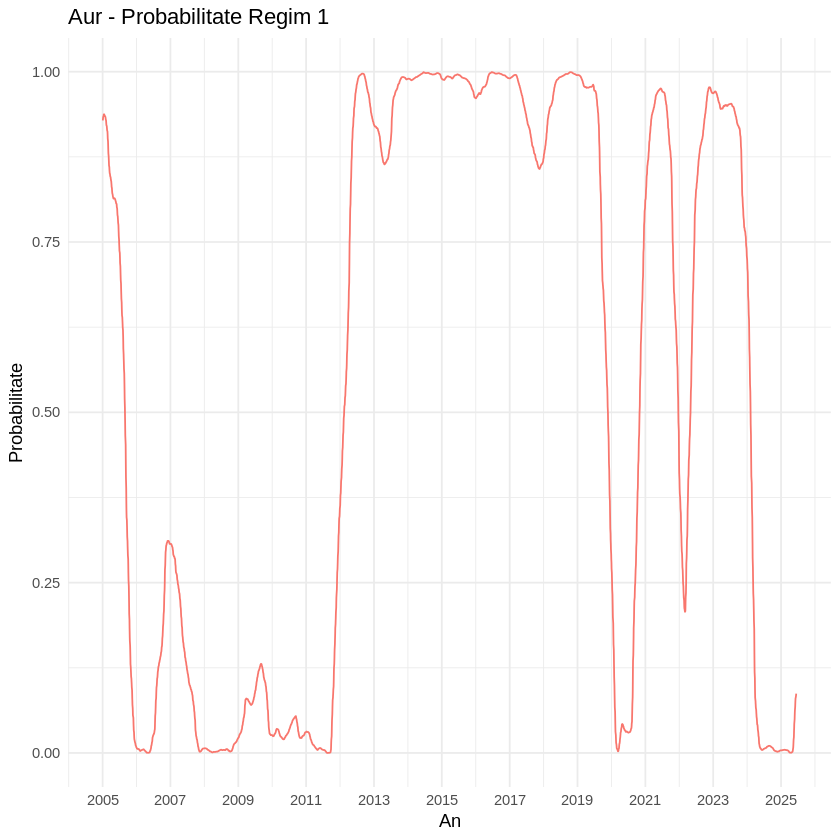

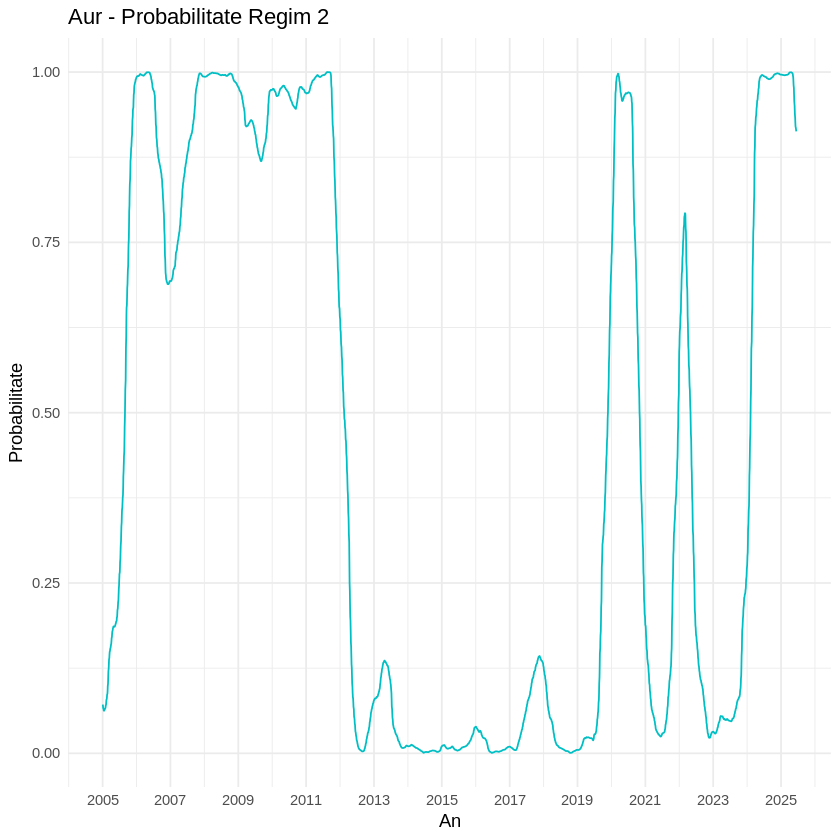

In [ ]:
library(ggplot2)

plot_msgarch_states <- function(state_object, dates, asset_name = "Asset") {

  # Extragem dimensiunile din SmoothProb
  dims <- dim(state_object$SmoothProb)
  n_obs <- dims[1]
  n_regimes <- dims[3]

  # Verificare de consistenta
  if(length(dates) != n_obs){
    stop(paste0("Lungimea date calendaristice (", length(dates),
                ") nu corespunde cu numarul de observatii din SmoothProb (", n_obs, ")!"))
  }

  # Extragem probabilitatile pe fiecare regim
  probs_list <- lapply(1:n_regimes, function(k) as.numeric(state_object$SmoothProb[,1,k]))

  # Construim dataframe-ul pentru plotting
  df_probabilitati <- data.frame(Date = dates, probs_list)
  colnames(df_probabilitati) <- c("Date", paste0("Regim", 1:n_regimes))

  # Generam graficele separat pentru fiecare regim
  for (k in 1:n_regimes) {
    p <- ggplot(df_probabilitati, aes_string(x = "Date", y = paste0("Regim", k))) +
      geom_line(color = scales::hue_pal()(n_regimes)[k]) +
      scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
      labs(title = paste(asset_name, "- Probabilitate Regim", k),
           x = "An", y = "Probabilitate") +
      theme_minimal()

    print(p)
  }
}

plot_msgarch_states(state_gold, gold_dates, asset_name = "Aur")

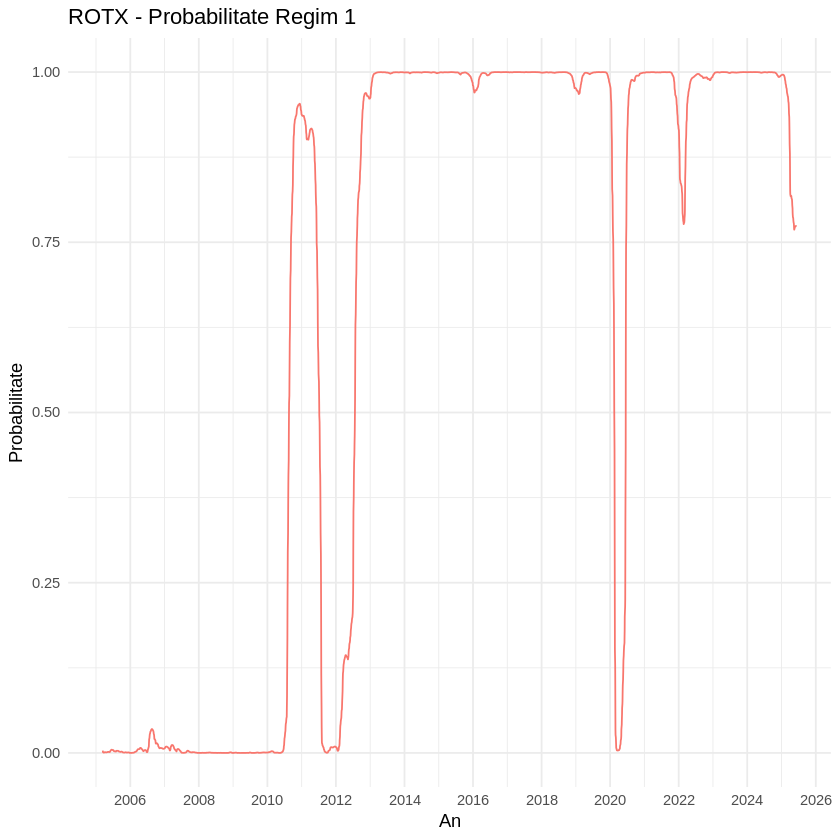

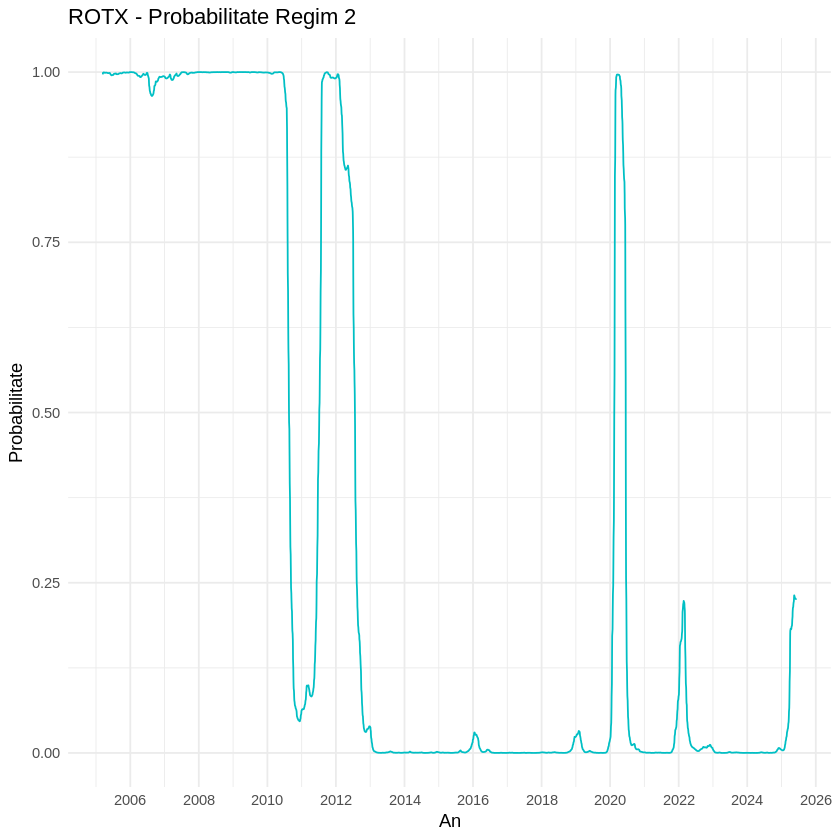

In [ ]:
plot_msgarch_states(state_rotx, rotx_dates, asset_name = "ROTX")

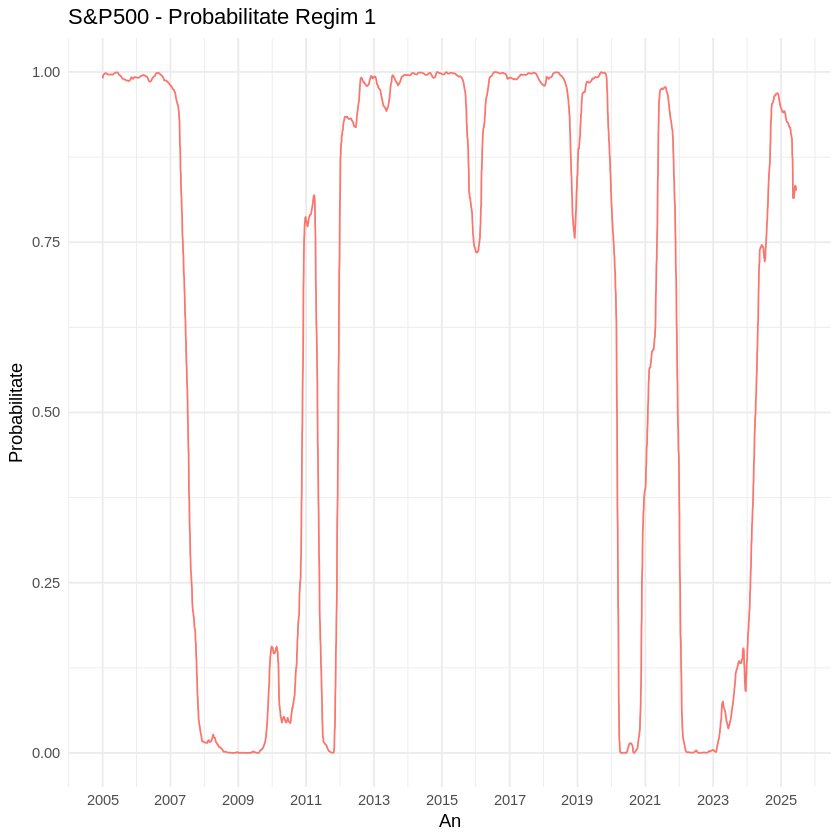

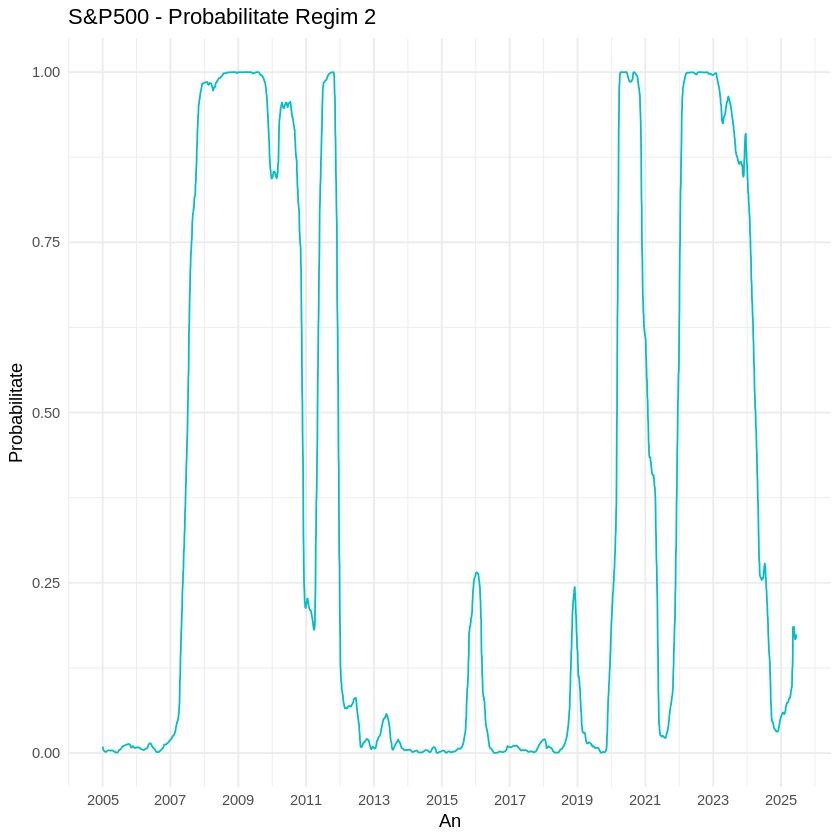

In [ ]:
plot_msgarch_states(state_sp500, sp500_dates, asset_name = "S&P500")

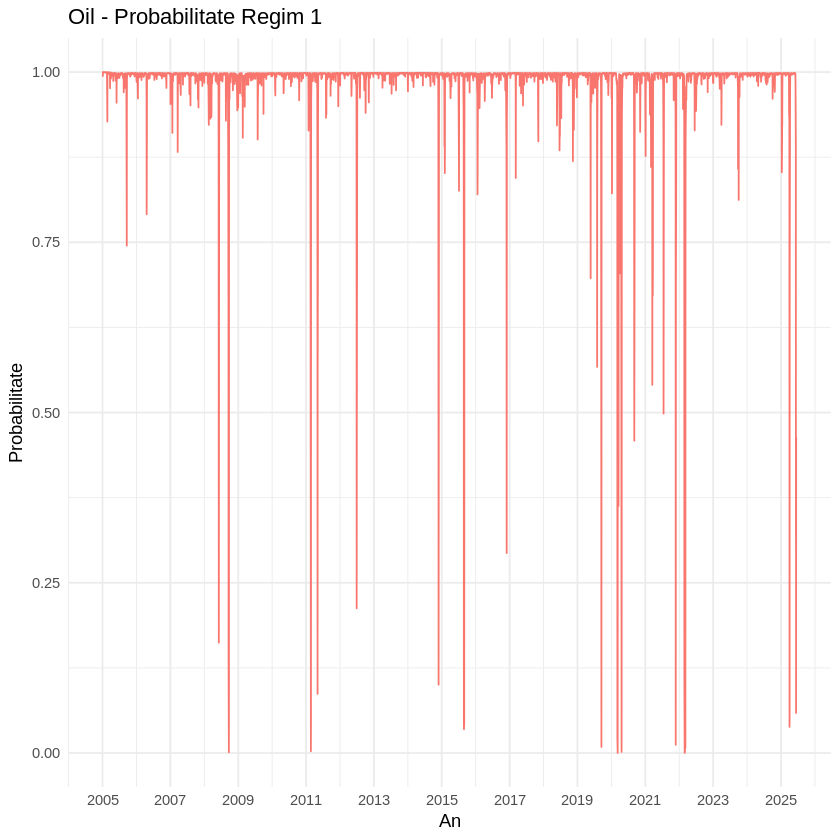

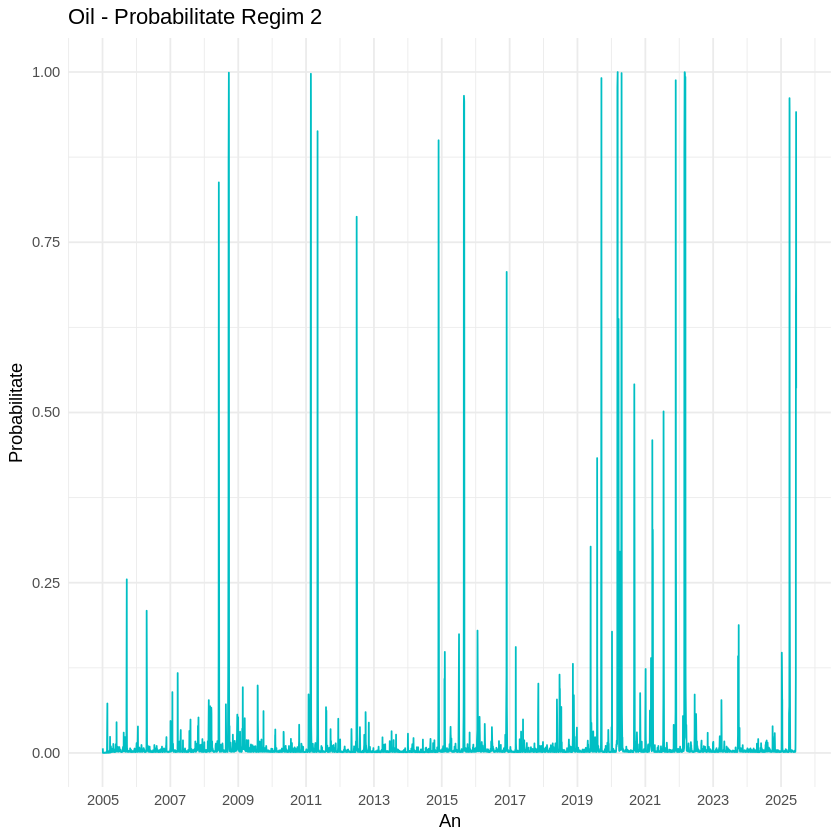

In [ ]:
plot_msgarch_states(state_oil, oil_dates, asset_name = "Oil")

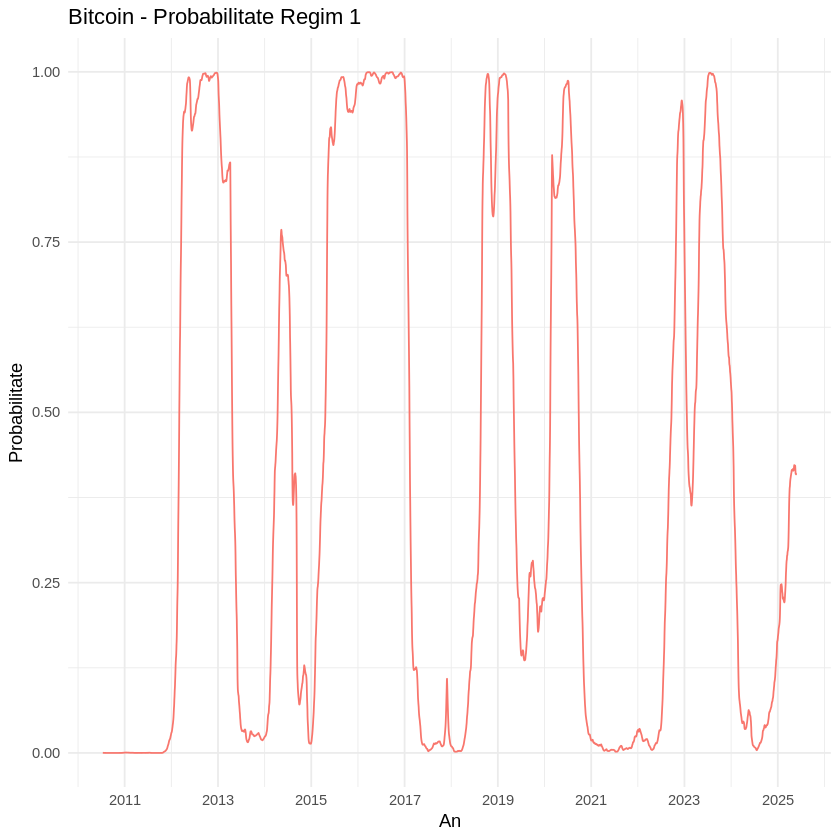

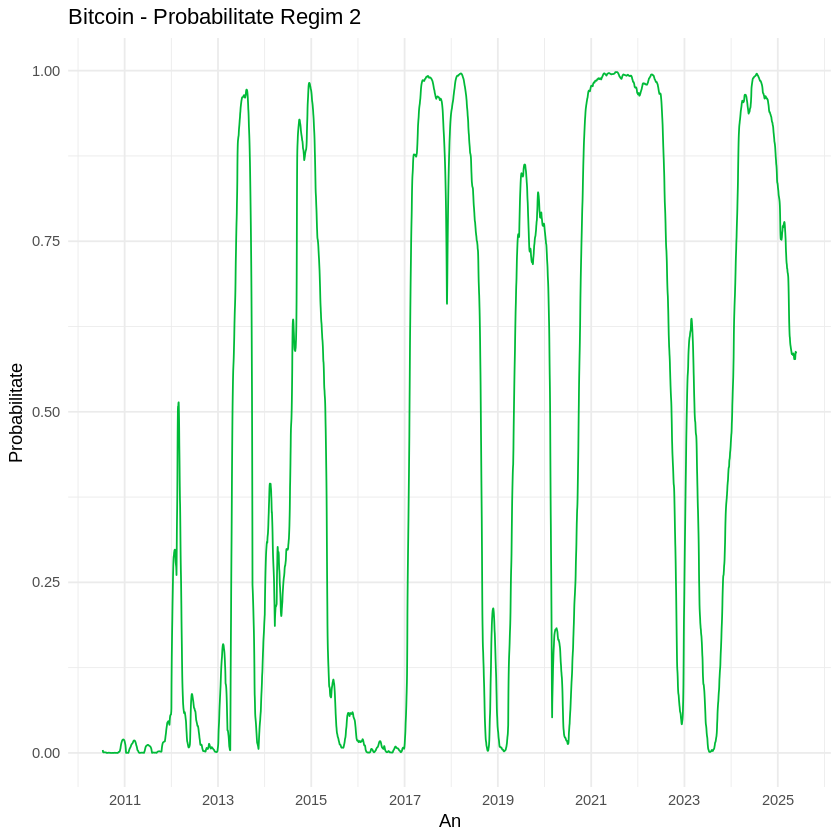

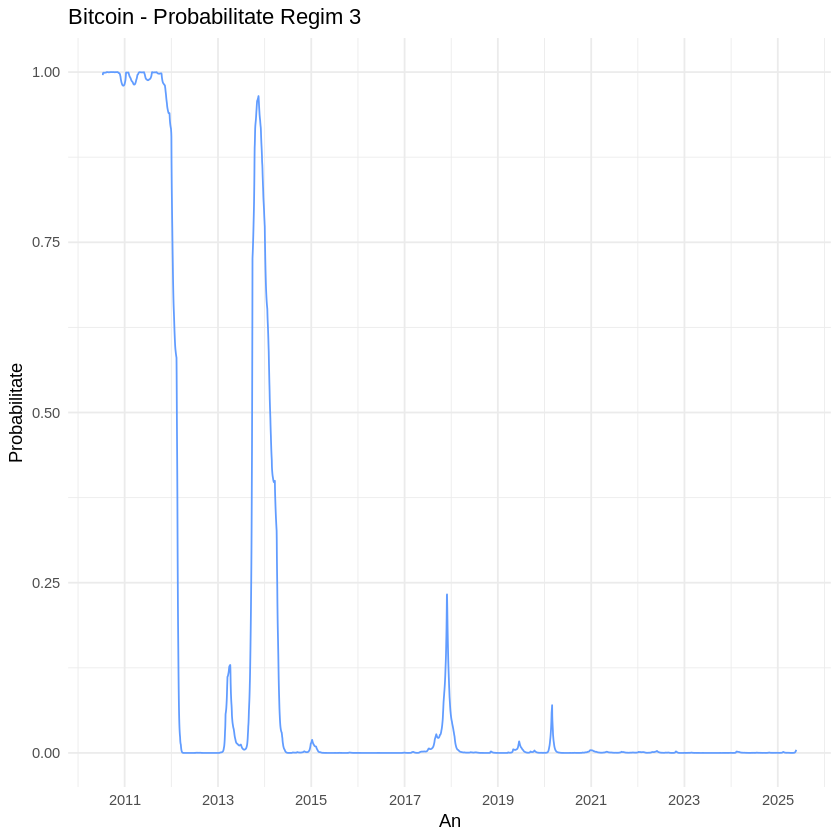

In [ ]:
plot_msgarch_states(state_bitcoin, bitcoin_dates, asset_name = "Bitcoin")

# **VOLATILITATE GARCH**

In [ ]:
library(ggplot2)

plot_msgarch_volatility <- function(fit_model, dates, asset_name = "Asset") {

  # Extragem volatilitatea din model
  vol <- Volatility(fit_model)
  vol <- as.numeric(vol)
  dates <- dates[-1]
  # Verificam lungimile
  if(length(vol) != length(dates)){
    stop(paste0("Lungimea date calendaristice (", length(dates),
                ") nu corespunde cu numarul de observatii de volatilitate (", length(vol), ")!"))
  }

  # Pregatim dataframe-ul
  df_vol <- data.frame(Date = dates, Volatility = vol)

  # Facem graficul frumos
  p <- ggplot(df_vol, aes(x = Date, y = Volatility)) +
    geom_line(color = "steelblue") +
    scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
    labs(title = paste(asset_name, "- Volatilitate estimata MSGARCH"),
         x = "An", y = "Volatilitate (σ)") +
    theme_minimal(base_size = 16)

  print(p)
}


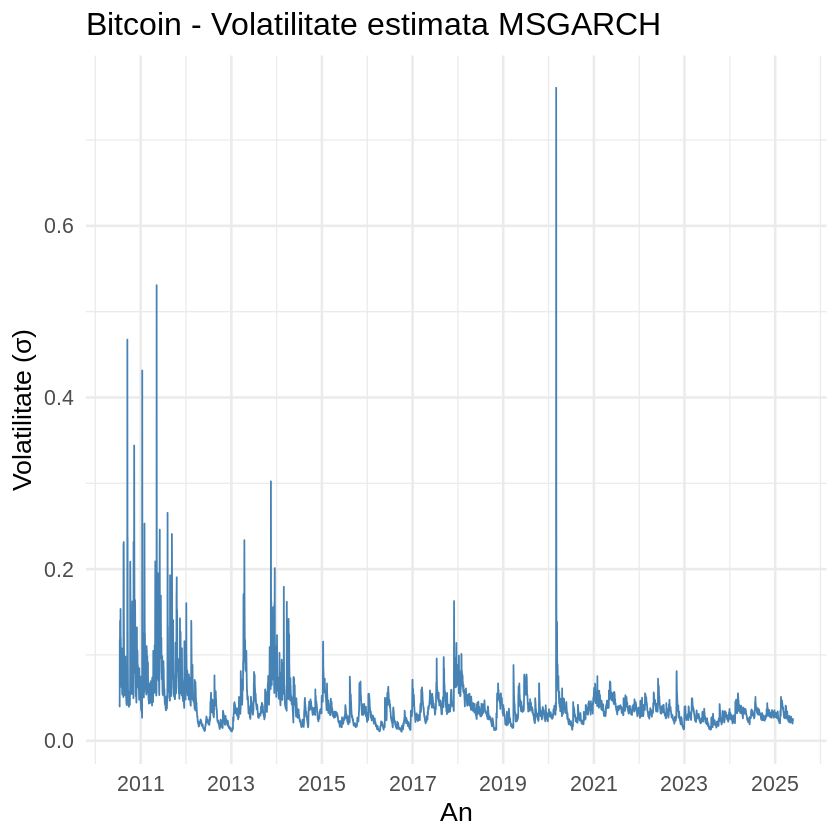

In [ ]:
plot_msgarch_volatility(fit_bitcoin, bitcoin_dates, asset_name = "Bitcoin")

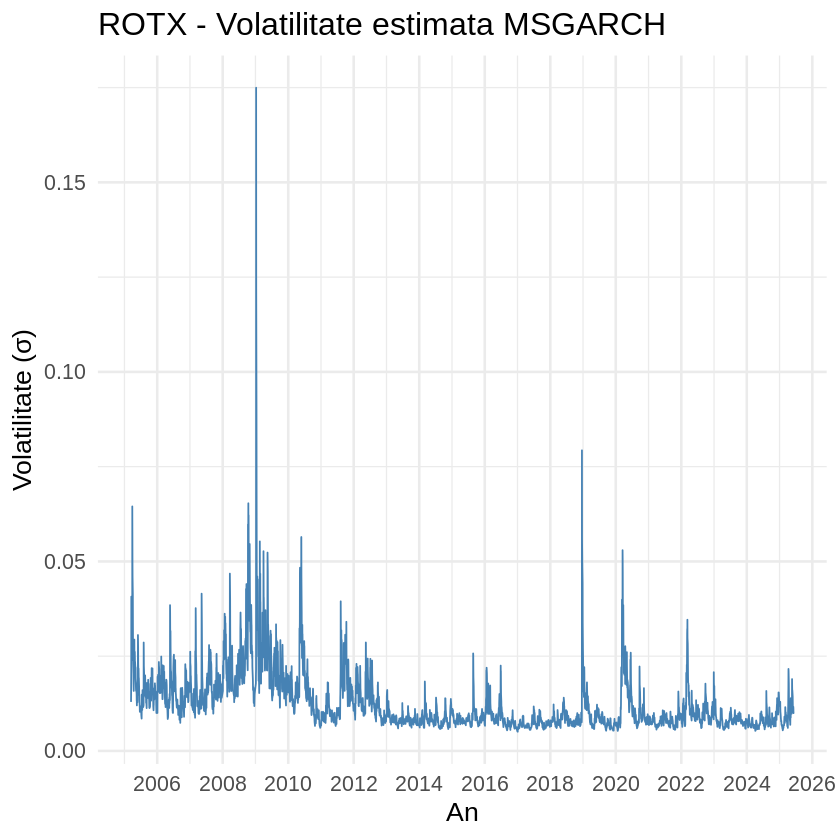

In [ ]:
plot_msgarch_volatility(fit_rotx, rotx_dates, asset_name = "ROTX")

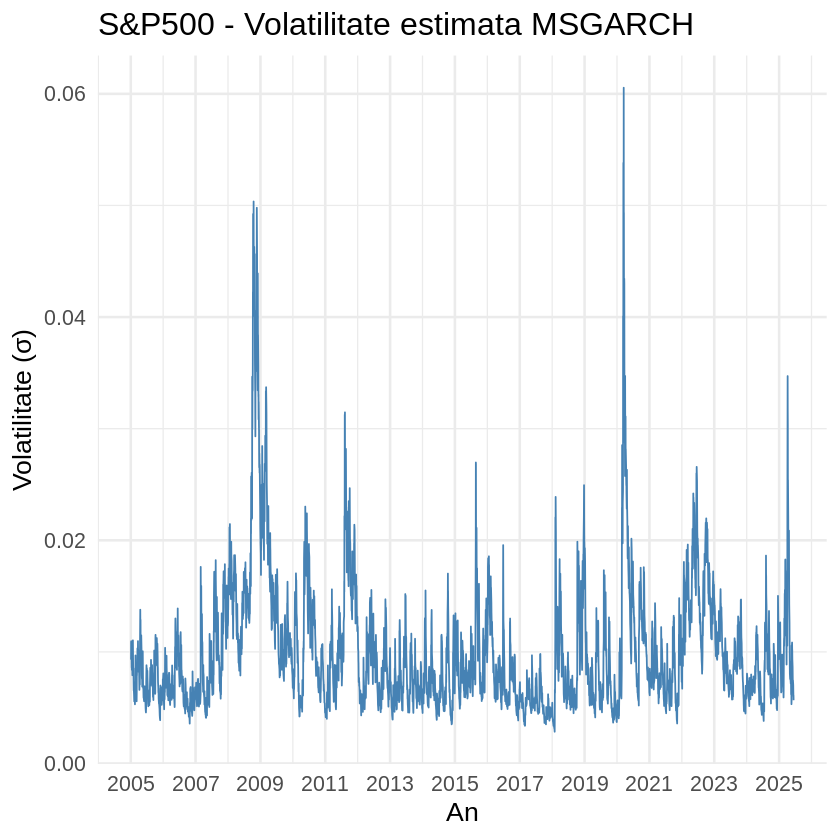

In [ ]:
plot_msgarch_volatility(fit_sp500, sp500_dates, asset_name = "S&P500")

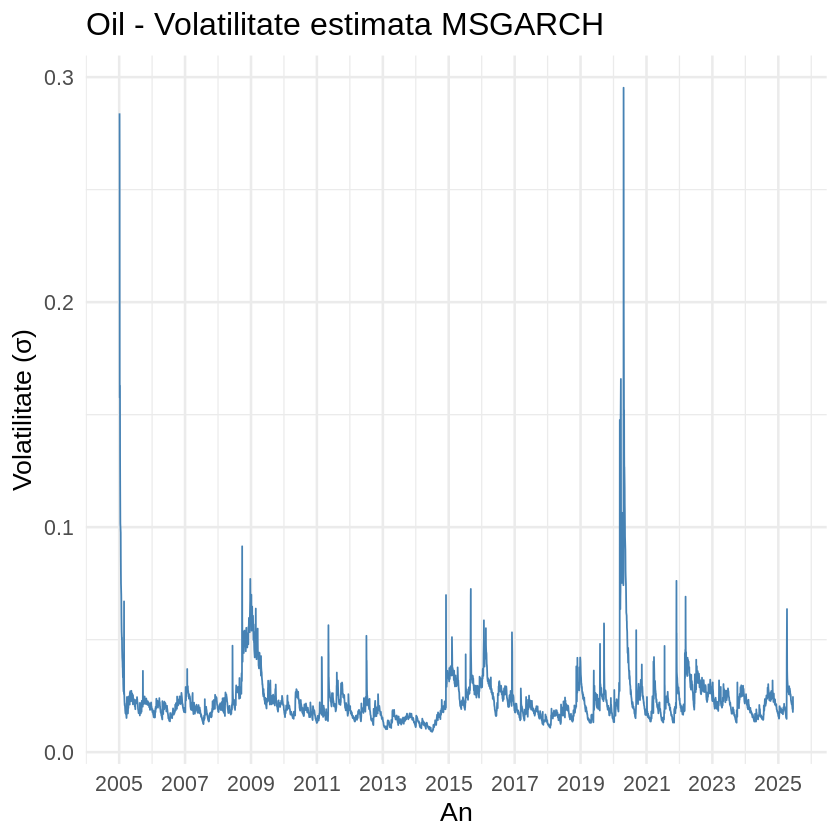

In [ ]:
plot_msgarch_volatility(fit_oil, oil_dates, asset_name = "Oil")

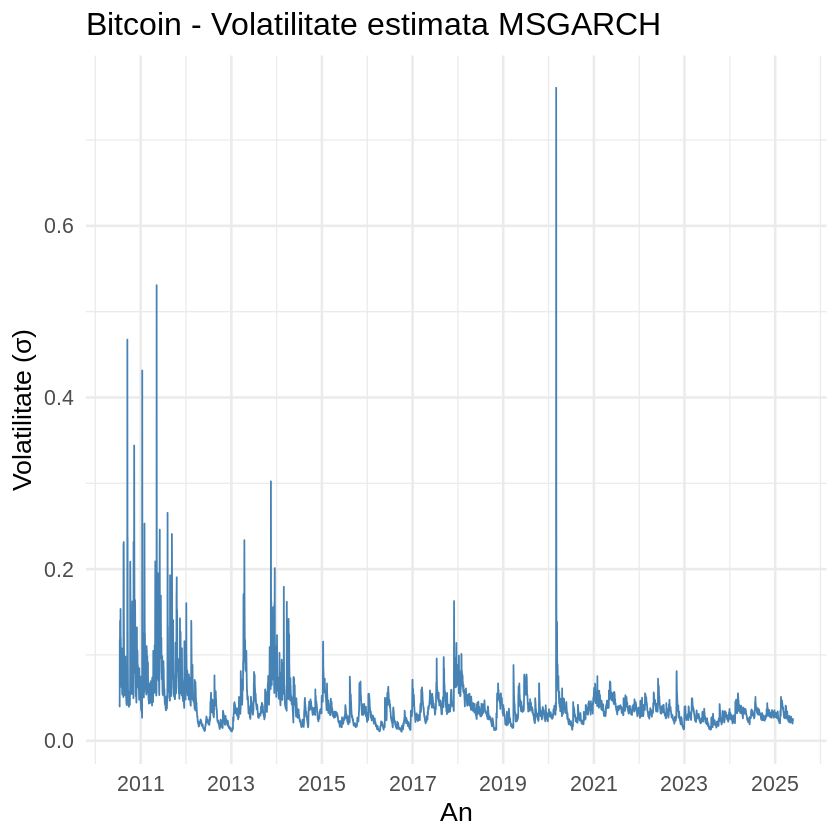

In [ ]:
plot_msgarch_volatility(fit_bitcoin, bitcoin_dates, asset_name = "Bitcoin")